In [ ]:
!pip install gym[classic_control]
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from base64 import b64encode
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 0. Simple Policy function

In [ ]:
def policy(matrix, weight):
    '''
    applies weights to a matrix like in NN. also softmax regularizes
    matrix : A x B matrix 
    weight : B x C matrix
    
    Returns : A x C matrix (policy)
    '''
    # apply weights like NN
    dot_product = matrix.dot(weight)
    # softmax regularize
    exp = np.exp(dot_product)
    policy = exp / np.sum(exp)
    return policy

In [ ]:
weight = np.ndarray((4, 2), buffer=np.array([
    [4.17022005e-01, 7.20324493e-01], 
    [1.14374817e-04, 3.02332573e-01], 
    [1.46755891e-01, 9.23385948e-02], 
    [1.86260211e-01, 3.45560727e-01]
    ]))


state = np.ndarray((1, 4), buffer=np.array([
    [-0.04428214,  0.01636746,  0.01196594, -0.03095031]
    ]))

res = policy(state, weight)
print(res)

[[0.50351642 0.49648358]]


In [ ]:
# [[0.50351642 0.49648358]]

## 1. Compute the Monte-Carlo policy gradient

In [ ]:
def policy_gradient(state, weight):
    """
    gets action and gradient based on monte-carlo algorithm

    state : state of environment A x B
    weight : current weights matrix B x C

    Returns :
      action - (int) next action to take
      gradient - gradient to apply to weights A x B
      
    """
    # get action prob. dist. from policy
    actions = policy(state, weight)
    # get action based on prob. dist.
    action = np.random.choice(len(actions[0]), p=actions[0])
    # reshaping to fit softmax
    s = actions.reshape(-1, 1)
    # apply softmax function to s and access value at action
    softmax = (np.diagflat(s) - np.dot(s, s.T))[action, :]
    # calculate the derivative of log as softmax / policy at action
    dlog = softmax / actions[0, action]
    # find gradient from input state matrix using dlog
    gradient = state.T.dot(dlog[None, :])
    # return action and the policy gradient
    return action, gradient

In [ ]:
env = gym.make('CartPole-v1')
np.random.seed(1)

weight = np.random.rand(4, 2)
state = env.reset()[None,:]
print(weight)
print(state)

action, grad = policy_gradient(state, weight)
print(action)
print(grad)

env.close()

[[4.17022005e-01 7.20324493e-01]
 [1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02]
 [1.86260211e-01 3.45560727e-01]]
[[ 0.03278486  0.01541823 -0.04351321 -0.0418852 ]]
0
[[ 0.01647684 -0.01647684]
 [ 0.00774881 -0.00774881]
 [-0.02186864  0.02186864]
 [-0.02105044  0.02105044]]


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [ ]:
'''
[[4.17022005e-01 7.20324493e-01]
 [1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02]
 [1.86260211e-01 3.45560727e-01]]
 
[[ 0.04228739 -0.04522399  0.01190918 -0.03496226]]

0

[[ 0.02106907 -0.02106907]
 [-0.02253219  0.02253219]
 [ 0.00593357 -0.00593357]
 [-0.01741943  0.01741943]]
'''

'\n[[4.17022005e-01 7.20324493e-01]\n [1.14374817e-04 3.02332573e-01]\n [1.46755891e-01 9.23385948e-02]\n [1.86260211e-01 3.45560727e-01]]\n \n[[ 0.04228739 -0.04522399  0.01190918 -0.03496226]]\n\n0\n\n[[ 0.02106907 -0.02106907]\n [-0.02253219  0.02253219]\n [ 0.00593357 -0.00593357]\n [-0.01741943  0.01741943]]\n'

## 2. Implement the training

In [ ]:
def train(env, nb_episodes, alpha=0.000045, gamma=0.98, show_result=False):
    """
    'trains' a weights matrix based on monte-carlo policy gradient algorithm 
    
    env: initial environment
    nb_episodes: number of episodes used for training
    alpha: the learning rate
    gamma: the discount factor

    Returns :  list of scores from episodes
    """
    weights_list = []
    # assign weight randomly based on given environment
    weight = np.random.rand(4, 2)
    # to track scores of episodes
    all_scores = []
    # iterate over all episodes
    for episode in range(nb_episodes):
        state = env.reset()[None, :]
        gradients = []
        rewards = []
        sum_rewards = 0
        while True:
            # get action and gradient from policy_gradient function
            action, gradient = policy_gradient(state, weight)
            # use action to determine next state, reward, done
            next_state, reward, done, _ = env.step(action)
            # append gradient and reward to repective lists
            gradients.append(gradient)
            rewards.append(reward)
            # add the reward to the episode score
            sum_rewards += reward
            # if done, breaks the loop
            if done:
                break
            # else the state is reset to the next state
            state = next_state[None, :]
        
        rewards = np.array(rewards)
        for i in range(len(gradients)):
            weight += (alpha * gradients[i]) * (gamma ** rewards[i:] * rewards[i:]).sum()
        if episode == 0 or episode % 1000 == 0:
          weights_list.append(weight.copy())

        # append the episode's score to all_scores
        all_scores.append(sum_rewards)

        if episode % 100 == 0:
          print(f"ep{episode} : r{sum_rewards}", end='\t')
        if episode % 1000 == 0:
          print()

    # return all values of scores
    return all_scores, weights_list

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


ep0 : r83.0	
ep100 : r98.0	ep200 : r63.0	ep300 : r31.0	ep400 : r51.0	ep500 : r72.0	ep600 : r26.0	ep700 : r121.0	ep800 : r136.0	ep900 : r247.0	ep1000 : r124.0	
ep1100 : r173.0	ep1200 : r465.0	ep1300 : r296.0	ep1400 : r186.0	ep1500 : r243.0	ep1600 : r418.0	ep1700 : r500.0	ep1800 : r500.0	ep1900 : r470.0	ep2000 : r500.0	
ep2100 : r500.0	ep2200 : r500.0	ep2300 : r500.0	ep2400 : r500.0	ep2500 : r500.0	ep2600 : r393.0	ep2700 : r500.0	ep2800 : r500.0	ep2900 : r500.0	ep3000 : r500.0	
ep3100 : r500.0	ep3200 : r500.0	ep3300 : r500.0	ep3400 : r500.0	ep3500 : r500.0	ep3600 : r500.0	ep3700 : r500.0	ep3800 : r362.0	ep3900 : r500.0	ep4000 : r137.0	
ep4100 : r500.0	ep4200 : r500.0	ep4300 : r500.0	ep4400 : r500.0	ep4500 : r500.0	ep4600 : r500.0	ep4700 : r500.0	ep4800 : r500.0	ep4900 : r500.0	ep5000 : r500.0	
ep5100 : r500.0	ep5200 : r500.0	ep5300 : r500.0	ep5400 : r500.0	ep5500 : r500.0	ep5600 : r500.0	ep5700 : r500.0	ep5800 : r500.0	ep5900 : r500.0	ep6000 : r500.0	
ep6100 : r500.0	ep6200 : r500.0	ep63

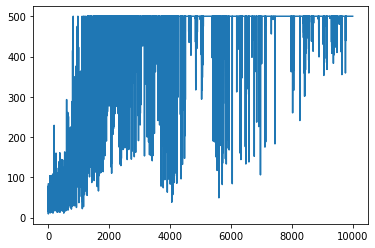

In [ ]:
env = gym.make('CartPole-v1')

start_time = time.time()
scores, weights_list = train(env, 10000)
print(f"--- {(time.time() - start_time)} seconds ---")

plt.plot(np.arange(len(scores)), scores)
plt.show()
env.close()

## Render function

In [ ]:
def render(weights_list, movie_save_path):
    i = 0
    for weights in weights_list:
      fig, ax = plt.subplots()
      ims = []
      state = env.reset()
      # get action prob. dist. from policy
      actions = policy(state, weights)
      # get action based on prob. dist.
      action = np.random.choice(len(actions), p=actions)
      done = False
      frame = 1
      while not done:
          # get action prob. dist. from policy
          actions = policy(state, weights)
          # get action based on prob. dist.
          action = np.random.choice(len(actions), p=actions)
          # use action to determine next state, reward, done
          state, reward, done, _ = env.step(action)
          if frame == 0 or frame % 3 == 0:
            im = env.render(mode='rgb_array')
            im = ax.imshow(im, animated=True)
            ims.append([im])
          frame += 1

      ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                      repeat_delay=1000)
      ani.save(movie_save_path + str(i) + ".mp4")
      i += 1

def view(move_save_path):
      mp4 = open(movie_save_path,'rb').read()
      data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
      HTML("""
      <video width=400 controls>
            <source src="%s" type="video/mp4">
      </video>
      """ % data_url)

/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: 

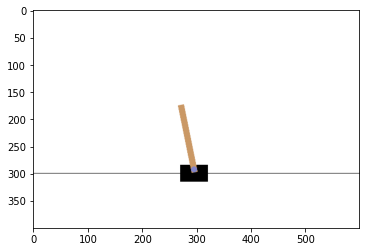

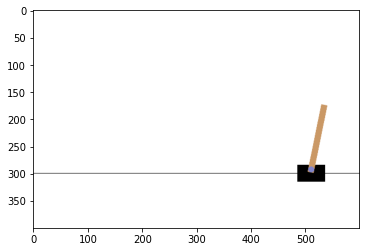

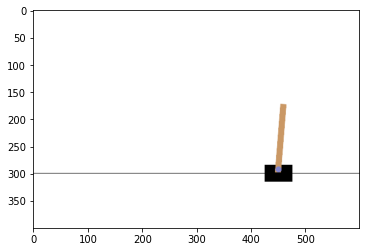

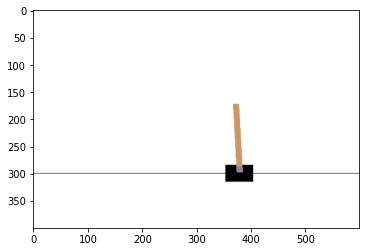

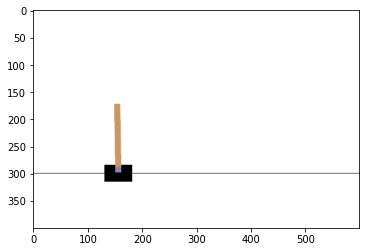

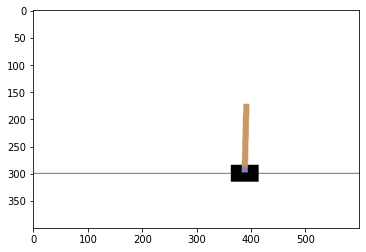

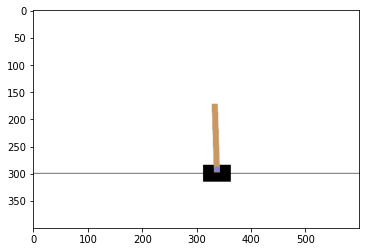

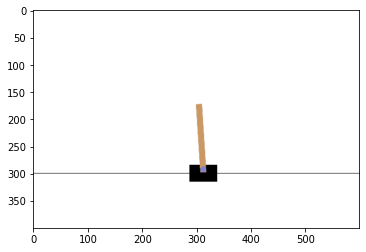

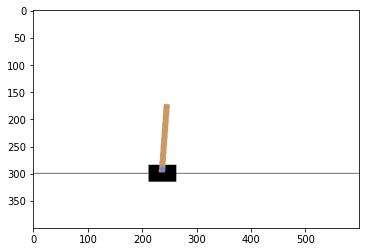

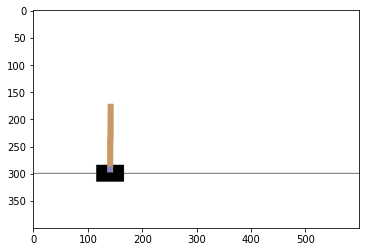

In [ ]:
render(weights_list, '/content/mov')

## render episode 0

In [ ]:
movie_save_path = "/content/mov0.mp4"
mp4 = open(movie_save_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## render episode 1000

In [ ]:
movie_save_path = "/content/mov1.mp4"
mp4 = open(movie_save_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## render episode 10000

In [ ]:
movie_save_path = "/content/mov9.mp4"
mp4 = open(movie_save_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)